# Dataset クラスの定義

### 環境構築とデータセットのダウンロード

In [33]:
# ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageDraw, ImageFont
from xml.etree.ElementTree import parse

import torch
import torchvision
from torchvision import transforms

In [34]:
%%capture
!if [ ! -d BCCD_Dataset ]; then git clone https://github.com/Shenggan/BCCD_Dataset.git; fi

### Dataset クラスの定義

PyTorch で Faster R-CNN が定義されたクラスでは、以下の形式となるように Dataset クラスを準備する必要があります。



*   image: 入力値
*   target: 目標値

 *   boxes: 座標位置
 *   labels: クラスラベル





In [35]:
# 物体検出では背景 (BG: background) も 1 クラスと扱います。
bccd_labels = ['BG', 'RBC', 'WBC', 'Platelets']

In [36]:
class BCCDDataset(torch.utils.data.Dataset):

    def __init__(self, root, mode='train'):
        self.root = root
        self.bccd_labels = ['BG', 'RBC', 'WBC', 'Platelets']
        self.transform = transforms.Compose([ transforms.ToTensor() ])
        with open(f'{root}/ImageSets/Main/{mode}.txt', 'r') as f:
            self.data_list = f.read().split('\n')[:-1]
    

    def __len__(self):
        return len(self.data_list)


    def __getitem__(self, idx):
        data = self.data_list[idx]

        # 入力値
        image_path = f'{self.root}/JPEGImages/{data}.jpg'
        image = Image.open(image_path)
        image = self.transform(image)

        # 目標値
        anno_path = f'{self.root}/Annotations/{data}.xml'
        parser = parse(anno_path)
        labels, boxes = [], []

        for obj in parser.findall('object'):
            box = [int(tag.text) for tag in obj.find('bndbox')] # box=[xmin, ymin, xmax, ymax]
            label = obj.find('name').text
            label = self.bccd_labels.index(label) # ラベルを要素番号（1, 2, 3...）に
            boxes.append(box)
            labels.append(label)

        boxes = torch.tensor(boxes, dtype=torch.float32) # 回帰：float32
        labels = torch.tensor(labels, dtype=torch.int64) # 分類：int
        
        target = {'boxes': boxes, 'labels': labels}

        return image, target

In [37]:
root = 'BCCD_Dataset/BCCD'

In [38]:
dataset = BCCDDataset(root)

In [39]:
len(dataset)

205

In [40]:
x, t = dataset[0]

In [41]:
# 入力値の確認
type(x), x.dtype, x.shape

(torch.Tensor, torch.float32, torch.Size([3, 480, 640]))

In [42]:
# 目標値の確認
t

{'boxes': tensor([[ 68., 315., 286., 480.],
         [346., 361., 446., 454.],
         [ 53., 179., 146., 299.],
         [449., 400., 536., 480.],
         [461., 132., 548., 212.],
         [454., 295., 541., 375.],
         [417., 283., 508., 383.],
         [278., 342., 369., 451.],
         [545.,  62., 636., 159.],
         [485.,  91., 576., 188.],
         [376., 171., 438., 253.],
         [329., 177., 395., 271.],
         [291.,  59., 407., 168.],
         [299.,   1., 404.,  68.],
         [346.,  26., 449., 138.],
         [134.,   1., 241.,  95.],
         [  1.,  38.,  98., 164.],
         [165., 160., 257., 264.],
         [464., 209., 566., 319.]]),
 'labels': tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

### 可視化

In [43]:
# フォントのダウンロード
%%capture
!if [ ! -d fonts ]; then mkdir fonts && cd fonts && wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip && unzip NotoSansCJKjp-hinted.zip && cd .. ;fi

In [44]:
def visualize_results(input, output):
    image= input.permute(1, 2, 0).numpy() # (ch: 0, h: 1, w: 2 -> h: 1, w: 2, ch: 0)
    image = Image.fromarray((image*255).astype(np.uint8))

    boxes = output['boxes'].cpu().detach().numpy()
    labels = output['labels'].cpu().detach().numpy()

    if 'scores' in output.keys():
        scores = output['scores'].cpu().detach().numpy()
        boxes = boxes[scores > 0.5]
        labels = labels[scores > 0.5]

    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype('fonts/NotoSansCJKjp-Bold.otf', 16)
    for box, label in zip(boxes, labels):
        # box
        draw.rectangle(box, outline='red')
        # label
        text = bccd_labels[label]
        w, h = font.getsize(text)
        draw.rectangle([box[0], box[1], box[0]+w, box[1]+h], fill='red')
        draw.text((box[0], box[1]), text, font=font, fill='white')

    return image

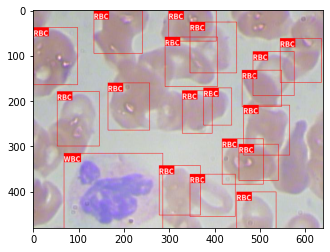

In [45]:
# 入力値と目標値を描画
image = visualize_results(x, t)
plt.imshow(image)

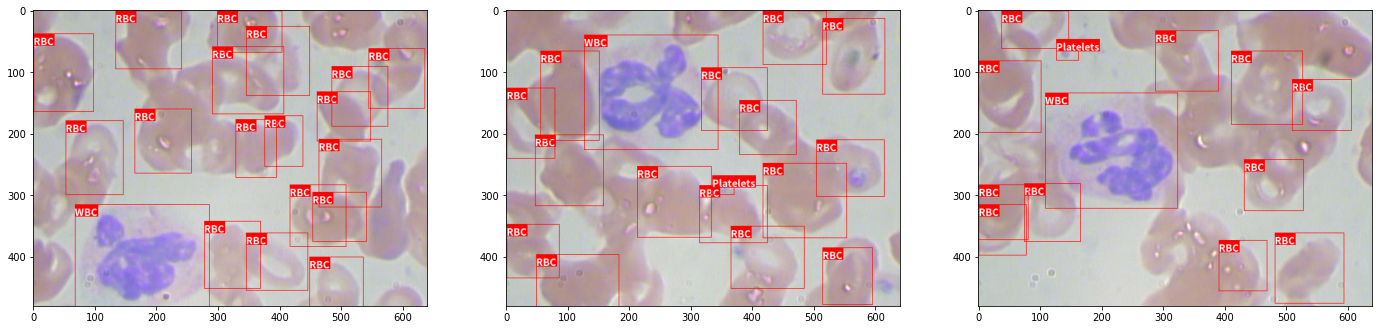

In [46]:
# 3 枚で確認
plt.figure(figsize=(24, 12))
for n in range(3):
    x, t = dataset[n]
    image = visualize_results(x, t)
    plt.subplot(1, 3, n+1)
    plt.imshow(image)